In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
# import keras
# from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error

In [97]:
df = pd.read_csv('/home/akhil/Downloads/Binance_BTCUSDT_d1.csv', index_col='date')
target_col = 'close'
df = df.iloc[::-1]

In [98]:
def fill_na(df, feature):       # filling null values based on current distribution
    s = df[feature].value_counts(normalize=True)
    missing = df[feature].isnull()
    df.loc[missing,feature] = np.random.choice(s.index, size=len(df[missing]),p=s.values)
fill_na(df, 'tradecount')   # also considering to replace with mean

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1381 entries, 2017-08-17 to 2021-05-27 00:00:00
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unix         1381 non-null   int64  
 1   symbol       1381 non-null   object 
 2   open         1381 non-null   float64
 3   high         1381 non-null   float64
 4   low          1381 non-null   float64
 5   close        1381 non-null   float64
 6   Volume BTC   1381 non-null   float64
 7   Volume USDT  1381 non-null   float64
 8   tradecount   1381 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 107.9+ KB


In [100]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

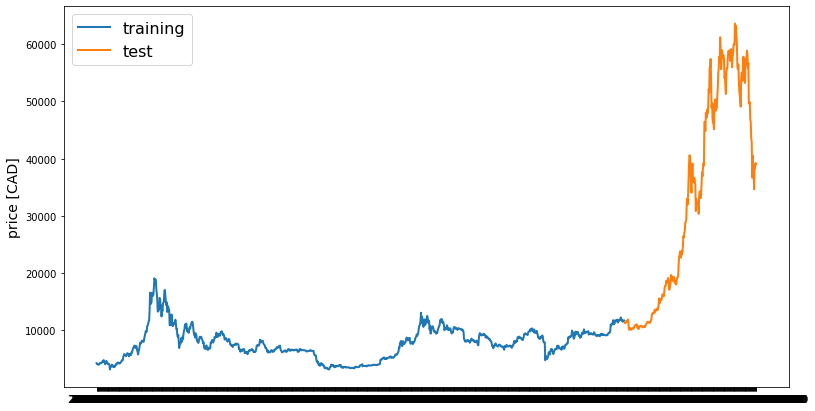

In [101]:
train, test = train_test_split(df, test_size=0.2)
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [102]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [103]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [104]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = tf.keras.Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [105]:
np.random.seed(42)
window_len = 3
test_size = 0.2
zero_base = True
lstm_neurons = 200
epochs = 40
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
df.drop(['symbol'],axis=1, inplace=True)

In [106]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [107]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/40
35/35 [==============================] - 2s 6ms/step - loss: 0.0060
Epoch 2/40
35/35 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 3/40
35/35 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 4/40
35/35 [==============================] - 0s 8ms/step - loss: 0.0027
Epoch 5/40
35/35 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 6/40
35/35 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 7/40
35/35 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 8/40
35/35 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 9/40
35/35 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 10/40
35/35 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 11/40
35/35 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 12/40
35/35 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 13/40
35/35 [==============================

In [108]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.02961870751238039

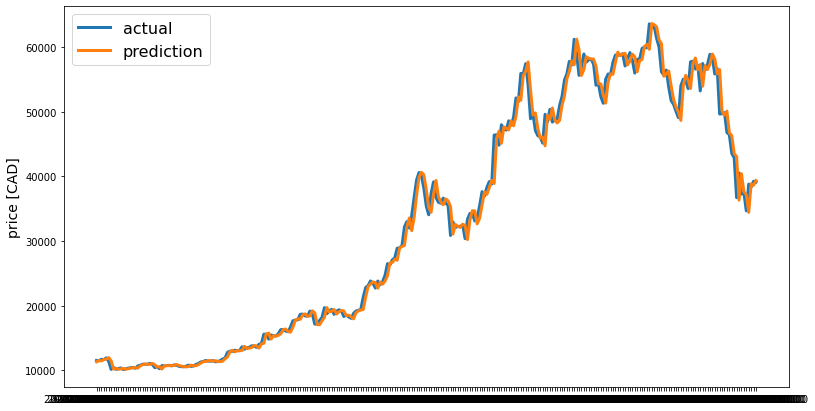

In [109]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [148]:
from pmdarima.arima import auto_arima
from statsmodels import adfuller

ImportError: cannot import name 'adfuller' from 'statsmodels' (/home/akhil/.local/lib/python3.8/site-packages/statsmodels/__init__.py)

In [111]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df.close)

(0.7186511978094956, True)

In [146]:
def test_stationarity(timeseries,maxlag):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=maxlag,
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))
test_stationarity(train.close, 1)

Results of Dickey-Fuller Test:


NameError: name 'adfuller' is not defined

In [144]:
arima_model=auto_arima(train.close, start_p=1, d=1,start_q=1, max_p=5,max_d=5,max_q=5,start_P=0, start_Q=0, maxx_P=10, max_Q=10,D=1, max_D=10,error_action='warn', trace=True, suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16344.019, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16340.047, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16342.034, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16342.041, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16338.370, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.689 seconds


In [142]:
arima_model.fit(train.close)
predictions = pd.DataFrame(arima_model.predict(n_periods=50))
predictions.columns = ['close']
predictions

,close
0,11706.497284
1,11665.249901
2,11624.452882
3,11584.101308
4,11544.190315
5,11504.715094
6,11465.670886
7,11427.052985
8,11388.856737
9,11351.077537


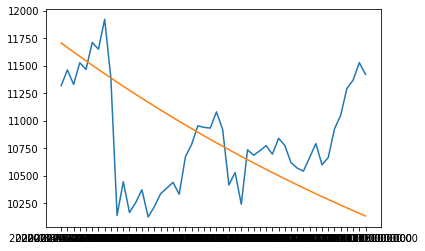

In [139]:
plt.plot(test.close.iloc[:50])
plt.plot(predictions)

In [140]:
train.close.iloc[-10:]

date
2020-08-15 00:00:00    11852.40
2020-08-16 00:00:00    11911.00
2020-08-17 00:00:00    12281.13
2020-08-18 00:00:00    11945.01
2020-08-19 00:00:00    11754.59
2020-08-20 00:00:00    11853.55
2020-08-21 00:00:00    11531.34
2020-08-22 00:00:00    11662.96
2020-08-23 00:00:00    11648.13
2020-08-24 00:00:00    11748.20
Name: close, dtype: float64